In [1]:
import pickle
from model_and_circuit import *
from jax.lib import xla_bridge
jax.experimental.enable_x64()
print("JAX Backend:", xla_bridge.get_backend().platform)

JAX Backend: gpu


In [2]:
def random_init(num_qubits,distribution=targetp_distribution):
    
    all_states = np.array([format(i, f'0{num_qubits}b') for i in range(2**num_qubits)])
    amps = jnp.zeros(n_qubits+1,dtype=jnp.float64)
    
    particle_number_states = {i: [] for i in range(num_qubits + 1)}
    for i in range(len(all_states)):
        k = all_states[i]
        # Use JAX to find states corresponding to the current particle number
        num_of_ones = k.count('1')
        particle_number_states[num_of_ones].append(k)

    return particle_number_states

# random_init(10,targetp_distribution)

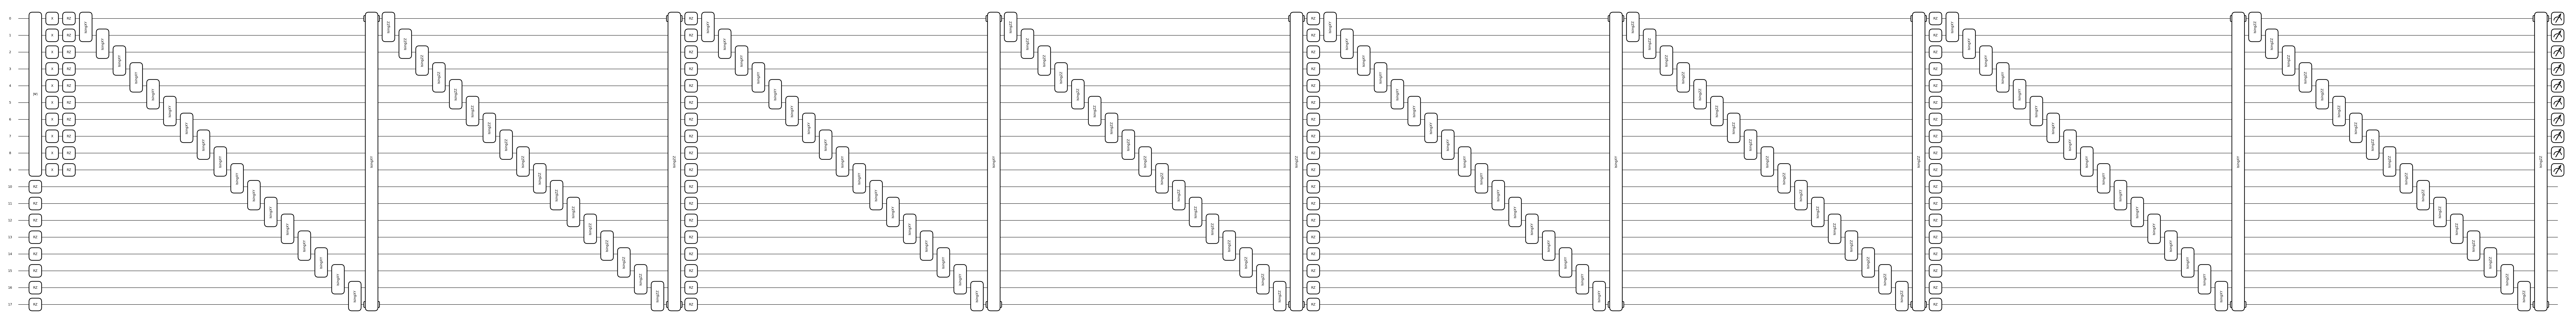

In [3]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.show()

In [4]:
class MMD:
    def __init__(self,scales,space):
        gammas = 1/(2*(scales**2)).reshape(-1,1,1)
        sq_dists = jnp.abs(space[:,None] - space[None,:])**2
        self.K = jnp.sum(jnp.exp(-gammas * sq_dists), axis=0)/len(scales)
        self.scales = scales
        
    def k_expval(self,px,py):
        return px @ self.K @ py
    
    def __call__(self,px,py):
        pxy = px-py
        return self.k_expval(pxy,pxy)
    
class QCBM:
    def __init__(self,circ,mmd,py):
        self.circ = circ
        self.mmd = mmd
        self.py = py
    
    def mmd_loss(self,params):
        px = self.circ(params)
        return self.mmd(px,self.py), px
    

#Model Training
@jit
def update_step(params,opt_state):
    
    (loss_val,qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss,has_aux=True)(params)

    updates,opt_state = opt.update(grads,opt_state)
    params = optax.apply_updates(params,updates)
    
    qcbm_probs = jnp.asarray(qcbm_probs, dtype=jnp.float64)
    
    kl_div = -jnp.sum(target_distribution * jnp.nan_to_num(jnp.log(qcbm_probs) - jnp.log(target_distribution)))
    
    return params, opt_state, loss_val, kl_div


In [5]:
# #Load the Checkpoint

# with open('/home/akashm/PROJECT/Hiwi_qml/qcbm/model/data_ancilla/model_checkpoint_0.01_13135.pkl', "rb") as file:
#     checkpoint = pickle.load(file)

# start_epoch = checkpoint["final_epoch"] + 1
# weights = checkpoint["parameters"]
# loss_values = checkpoint["history"]
# kl_values = checkpoint["divs"]

# print(f"Resuming training from epoch {start_epoch}...")

In [6]:
#Calling MMD class
bandwidth = jnp.array([0.25,60],dtype=jnp.float64)
space = jnp.arange(0,2**n_qubits,dtype=jnp.float64)
mmd = MMD(bandwidth,space=space)


#Calling QCBM class to run the previous built circuit with random weights
qcbm = QCBM(circuit,mmd=mmd,py=target_distribution)


#Initial parameters
weights = initial_params
lr = optax.exponential_decay(init_value=0.1,transition_steps=10,decay_rate=0.99,transition_begin=300,end_value=0.025,staircase=True)
# lr = 0.1
opt = optax.adam(learning_rate=lr)
opt_state = opt.init(weights)


history = []
divs = []
parameters = []


kl_div = 1
i = 0
# i = start_epoch

# while kl_div > 10^-3:
while i < 1001:
    i+=1
    current_lr = lr(i)
    # current_lr = lr
    start_time = time.time()
    weights, opt_state, loss_val, kl_div = update_step(params=weights,opt_state=opt_state)
    end_time = time.time()
    
    if i%10==0:
        print(f"Step: {i} Loss: {loss_val} KL_div:{kl_div} current_lr:{current_lr} Time taken per iteration: {end_time-start_time}")
    
    history.append(loss_val)
    divs.append(kl_div)
    parameters.append(weights)
    

Step: 10 Loss: 0.10953471809625626 KL_div:1.4880237976441857e+37 current_lr:0.10000000149011612 Time taken per iteration: 0.1469876766204834
Step: 20 Loss: 0.04241287335753441 KL_div:1.4540876501905358e+37 current_lr:0.10000000149011612 Time taken per iteration: 0.13763022422790527
Step: 30 Loss: 0.024371366947889328 KL_div:1.4540876501905358e+37 current_lr:0.10000000149011612 Time taken per iteration: 0.14822649955749512
Step: 40 Loss: 0.0231020525097847 KL_div:1.4540876501905358e+37 current_lr:0.10000000149011612 Time taken per iteration: 0.14517951011657715
Step: 50 Loss: 0.022594990208745003 KL_div:1.4540876501905358e+37 current_lr:0.10000000149011612 Time taken per iteration: 0.1401808261871338


KeyboardInterrupt: 

In [14]:
# import pickle

# #Save Checkpoint
# checkpoint = {"final_epoch":i,
#               "history":history,
#               "divs":divs,
#               "parameters":parameters}

# with open(f'model_checkpoint_{lr(i)}_{i}.pkl','wb') as file:
#     pickle.dump(checkpoint,file)
    
# print("Model saved successfully")


In [15]:
# fig, axs = plt.subplots(1,2,figsize=(15,8))
# axs[0].plot(kl_values)
# axs[0].title.set_text('KL Divergence')

# axs[1].plot(loss_values)
# axs[1].title.set_text('loss')

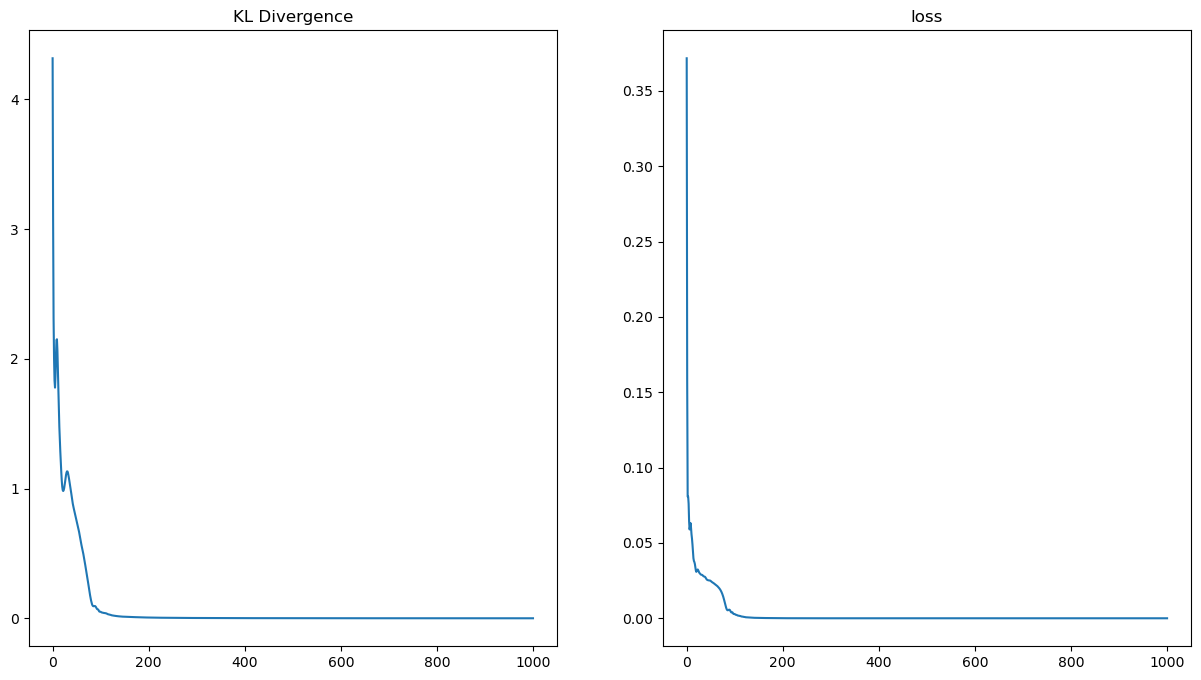

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,8))
axs[0].plot(divs)
axs[0].title.set_text('KL Divergence')

axs[1].plot(history)
axs[1].title.set_text('loss')

In [17]:
# optimal_params = weights[np.argmin(kl_values)]
# qcbm_probs = circuit(input_params=optimal_params)
# x_full = jnp.arange(0,2**n_qubits,dtype=jnp.float64)
# plt.bar(x_full,qcbm_probs,color='green',alpha=0.5,label='obtained_distribution')
# plt.plot(x_full,target_distribution,color='blue',alpha=0.5,label='target_distribution')

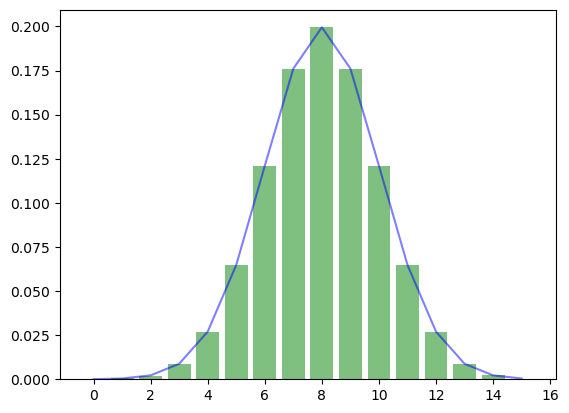

In [18]:
optimal_params = parameters[np.argmin(divs)]
qcbm_probs = circuit(optimal_params)
x_full = jnp.arange(0,2**n_qubits,dtype=jnp.float64)
plt.bar(x_full,qcbm_probs,color='green',alpha=0.5,label='obtained_distribution')
plt.plot(x_full,target_distribution,color='blue',alpha=0.5,label='target_distribution')

In [19]:
print(f"The minimum KL divergence obtained : {np.min(divs)}")

The minimum KL divergence obtained : 0.0004857064632233232
